In [1]:
from google.colab import drive
import os

WORK_DRIVE = '/gdrive'
WORK_AREA = WORK_DRIVE + '/MyDrive/Congressional Stock Price Forecasting/code/feature_engineering'

drive.mount(WORK_DRIVE, force_remount=True)
os.chdir(WORK_AREA)

os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/Congressional Stock Price Forecasting/code/feature_engineering'

### Yahoo Finance Data

In [2]:
import pandas as pd

pd.set_option('display.max_columns', 100)

df = pd.read_parquet('../../data/datasets/daily_stock_prices.parquet')

df.sort_values(by=['Date', 'Ticker'], ignore_index=True, inplace=True)

df

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2015-10-01 00:00:00+00:00,AAPL,24.740032,27.395000,27.405001,26.827499,27.267500,255716400.0
1,2015-10-01 00:00:00+00:00,AMGN,107.875710,140.229996,140.639999,136.600006,138.550003,4675900.0
2,2015-10-01 00:00:00+00:00,AXP,64.445457,73.889999,74.599998,73.209999,74.160004,4741100.0
3,2015-10-01 00:00:00+00:00,BA,116.415627,130.610001,131.789993,128.979996,131.320007,2878400.0
4,2015-10-01 00:00:00+00:00,CAT,50.774788,64.389999,66.099998,63.610001,65.629997,7933000.0
...,...,...,...,...,...,...,...,...
67014,2024-09-27 00:00:00+00:00,UNH,581.849976,581.849976,586.710022,576.590027,577.679993,2986200.0
67015,2024-09-27 00:00:00+00:00,V,275.170013,275.170013,277.980011,272.779999,273.160004,6509600.0
67016,2024-09-27 00:00:00+00:00,VZ,44.200008,44.889999,45.049999,44.490002,44.720001,15659300.0
67017,2024-09-27 00:00:00+00:00,WBA,9.060000,9.060000,9.200000,8.600000,8.610000,27385300.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67019 entries, 0 to 67018
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       67019 non-null  datetime64[ns, UTC]
 1   Ticker     67019 non-null  object             
 2   Adj Close  67019 non-null  float64            
 3   Close      67019 non-null  float64            
 4   High       67019 non-null  float64            
 5   Low        67019 non-null  float64            
 6   Open       67019 non-null  float64            
 7   Volume     67019 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), object(1)
memory usage: 4.1+ MB


In [4]:
df.drop(columns=['Close', 'High', 'Low', 'Open'], inplace=True)

df

,Date,Ticker,Adj Close,Volume
0,2015-10-01 00:00:00+00:00,AAPL,24.740032,255716400.0
1,2015-10-01 00:00:00+00:00,AMGN,107.875710,4675900.0
2,2015-10-01 00:00:00+00:00,AXP,64.445457,4741100.0
3,2015-10-01 00:00:00+00:00,BA,116.415627,2878400.0
4,2015-10-01 00:00:00+00:00,CAT,50.774788,7933000.0
...,...,...,...,...
67014,2024-09-27 00:00:00+00:00,UNH,581.849976,2986200.0
67015,2024-09-27 00:00:00+00:00,V,275.170013,6509600.0
67016,2024-09-27 00:00:00+00:00,VZ,44.200008,15659300.0
67017,2024-09-27 00:00:00+00:00,WBA,9.060000,27385300.0


Compute tabular features

In [5]:
import numpy as np

# Group by Ticker and calculate RSI
def calculate_rsi(group, window):
    # Calculate daily price change
    group['Change'] = group['Adj Close'].diff()

    # Calculate gains (positive changes) and losses (negative changes)
    group['Gain'] = np.where(group['Change'] > 0, group['Change'], 0)
    group['Loss'] = np.where(group['Change'] < 0, -group['Change'], 0)

    # Calculate rolling average gain and loss
    group[f'{window} Day Avg Gain'] = group['Gain'].rolling(window=window).mean()
    group[f'{window} Day Avg Loss'] = group['Loss'].rolling(window=window).mean()

    # Calculate Relative Strength (RS) and RSI
    # group[f'{window} Day RS'] = group[f'{window} Day Avg Gain'] / group[f'{window} Day Avg Loss']
    # group[f'{window} Day RSI'] = 100 - (100 / (1 + group[f'{window} Day RS']))

    group.drop(columns=['Change', 'Gain', 'Loss'], inplace=True)

    return group

# Apply RSI calculation for each ticker
df = df.groupby('Ticker').apply(lambda x: calculate_rsi(x, window=10), include_groups=True).reset_index(drop=True)
df = df.groupby('Ticker').apply(lambda x: calculate_rsi(x, window=30), include_groups=True).reset_index(drop=True)
df = df.groupby('Ticker').apply(lambda x: calculate_rsi(x, window=60), include_groups=True).reset_index(drop=True)

df

<ipython-input-5-df15ad65571d>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker').apply(lambda x: calculate_rsi(x, window=10), include_groups=True).reset_index(drop=True)
<ipython-input-5-df15ad65571d>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker').apply(lambda x: calculate_rsi(x, window=30), include_groups=True).reset_index(drop=True)
<ipython-input-5-d

,Date,Ticker,Adj Close,Volume,10 Day Avg Gain,10 Day Avg Loss,30 Day Avg Gain,30 Day Avg Loss,60 Day Avg Gain,60 Day Avg Loss
0,2015-10-01 00:00:00+00:00,AAPL,24.740032,255716400.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-10-02 00:00:00+00:00,AAPL,24.920649,232079200.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-10-05 00:00:00+00:00,AAPL,25.010963,208258800.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-10-06 00:00:00+00:00,AAPL,25.130623,192787200.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-10-07 00:00:00+00:00,AAPL,25.010963,187062400.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
67014,2024-09-23 00:00:00+00:00,WMT,80.330002,12147300.0,0.598,0.299,0.561384,0.142279,0.408494,0.197779
67015,2024-09-24 00:00:00+00:00,WMT,80.669998,14651100.0,0.485,0.299,0.547788,0.142279,0.414161,0.194954
67016,2024-09-25 00:00:00+00:00,WMT,81.400002,14163800.0,0.555,0.299,0.572122,0.123333,0.426328,0.191131
67017,2024-09-26 00:00:00+00:00,WMT,79.919998,17061100.0,0.473,0.447,0.554505,0.172667,0.416522,0.215798


In [6]:
df['60 Day Price Std'] = df.groupby(['Ticker'])['Adj Close'].shift([i for i in range(60)]).std(axis=1, skipna=False)
df['60 Day Price Mean'] = df.groupby(['Ticker'])['Adj Close'].shift([i for i in range(60)]).mean(axis=1, skipna=False)
df['60 Day Price 10th Percentile'] = df.groupby(['Ticker'])['Adj Close'].shift([i for i in range(60)]).quantile(0.10, axis=1)
df['60 Day Price 90th Percentile'] = df.groupby(['Ticker'])['Adj Close'].shift([i for i in range(60)]).quantile(0.90, axis=1)

df

,Date,Ticker,Adj Close,Volume,10 Day Avg Gain,10 Day Avg Loss,30 Day Avg Gain,30 Day Avg Loss,60 Day Avg Gain,60 Day Avg Loss,60 Day Price Std,60 Day Price Mean,60 Day Price 10th Percentile,60 Day Price 90th Percentile
0,2015-10-01 00:00:00+00:00,AAPL,24.740032,255716400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.740032,24.740032
1,2015-10-02 00:00:00+00:00,AAPL,24.920649,232079200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.758094,24.902587
2,2015-10-05 00:00:00+00:00,AAPL,25.010963,208258800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.776155,24.992900
3,2015-10-06 00:00:00+00:00,AAPL,25.130623,192787200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.794217,25.094725
4,2015-10-07 00:00:00+00:00,AAPL,25.010963,187062400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.812279,25.082759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67014,2024-09-23 00:00:00+00:00,WMT,80.330002,12147300.0,0.598,0.299,0.561384,0.142279,0.408494,0.197779,4.394505,72.645372,67.735919,78.858997
67015,2024-09-24 00:00:00+00:00,WMT,80.669998,14651100.0,0.485,0.299,0.547788,0.142279,0.414161,0.194954,4.461902,72.864579,67.864559,79.032999
67016,2024-09-25 00:00:00+00:00,WMT,81.400002,14163800.0,0.555,0.299,0.572122,0.123333,0.426328,0.191131,4.534321,73.099776,67.930366,79.119998
67017,2024-09-26 00:00:00+00:00,WMT,79.919998,17061100.0,0.473,0.447,0.554505,0.172667,0.416522,0.215798,4.565641,73.300500,68.035067,79.686003


Compute time-series features

In [7]:
import warnings

days_between = 10

for feature in ['Adj Close', 'Volume']:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        for i in range(5):
            df[f"{feature} Mean {i*days_between} to {i*days_between+days_between} Day Lag"] = df.groupby(['Ticker'])[feature].shift([i for i in range(i*days_between, i*days_between+days_between)]).mean(axis=1, skipna=False)
        for i in range(4):
            df[f"{feature} Mean {i*days_between} to {i*days_between+days_between} Day Lag Difference"] = df[f"{feature} Mean {i*days_between} to {i*days_between+days_between} Day Lag"] - df[f"{feature} Mean {(i+1)*days_between} to {(i+1)*days_between+days_between} Day Lag"]

df.drop(columns=[f"Volume Mean {i*days_between} to {i*days_between+days_between} Day Lag Difference" for i in range(4)], inplace=True)

df = df.copy()

df

,Date,Ticker,Adj Close,Volume,10 Day Avg Gain,10 Day Avg Loss,30 Day Avg Gain,30 Day Avg Loss,60 Day Avg Gain,60 Day Avg Loss,60 Day Price Std,60 Day Price Mean,60 Day Price 10th Percentile,60 Day Price 90th Percentile,Adj Close Mean 0 to 10 Day Lag,Adj Close Mean 10 to 20 Day Lag,Adj Close Mean 20 to 30 Day Lag,Adj Close Mean 30 to 40 Day Lag,Adj Close Mean 40 to 50 Day Lag,Adj Close Mean 0 to 10 Day Lag Difference,Adj Close Mean 10 to 20 Day Lag Difference,Adj Close Mean 20 to 30 Day Lag Difference,Adj Close Mean 30 to 40 Day Lag Difference,Volume Mean 0 to 10 Day Lag,Volume Mean 10 to 20 Day Lag,Volume Mean 20 to 30 Day Lag,Volume Mean 30 to 40 Day Lag,Volume Mean 40 to 50 Day Lag
0,2015-10-01 00:00:00+00:00,AAPL,24.740032,255716400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.740032,24.740032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-10-02 00:00:00+00:00,AAPL,24.920649,232079200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.758094,24.902587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-10-05 00:00:00+00:00,AAPL,25.010963,208258800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.776155,24.992900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-10-06 00:00:00+00:00,AAPL,25.130623,192787200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.794217,25.094725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-10-07 00:00:00+00:00,AAPL,25.010963,187062400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.812279,25.082759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67014,2024-09-23 00:00:00+00:00,WMT,80.330002,12147300.0,0.598,0.299,0.561384,0.142279,0.408494,0.197779,4.394505,72.645372,67.735919,78.858997,79.352999,76.723999,72.610793,68.160713,70.163005,2.629000,4.113206,4.450079,-2.002292,19038860.0,15696770.0,20809690.0,16698100.0,13592090.0
67015,2024-09-24 00:00:00+00:00,WMT,80.669998,14651100.0,0.485,0.299,0.547788,0.142279,0.414161,0.194954,4.461902,72.864579,67.864559,79.032999,79.538999,77.001999,73.363319,68.068974,70.164002,2.537000,3.638680,5.294345,-2.095028,18735340.0,16514580.0,20021980.0,17405100.0,13606510.0
67016,2024-09-25 00:00:00+00:00,WMT,81.400002,14163800.0,0.555,0.299,0.572122,0.123333,0.426328,0.191131,4.534321,73.099776,67.930366,79.119998,79.795000,77.272999,74.182684,67.963275,70.084230,2.522001,3.090314,6.219409,-2.120955,18199840.0,17310680.0,18521970.0,18808640.0,13875080.0
67017,2024-09-26 00:00:00+00:00,WMT,79.919998,17061100.0,0.473,0.447,0.554505,0.172667,0.416522,0.215798,4.565641,73.300500,68.035067,79.686003,79.820999,77.630999,74.944199,67.965270,69.845909,2.190000,2.686800,6.978929,-1.880639,18417460.0,17817740.0,17210540.0,18810620.0,14812580.0


Get target variable

In [8]:
df.insert(df.columns.get_loc('Adj Close'), 'Adj Close in 60 Days', df.groupby(['Ticker'])['Adj Close'].shift(-60))

df

,Date,Ticker,Adj Close in 60 Days,Adj Close,Volume,10 Day Avg Gain,10 Day Avg Loss,30 Day Avg Gain,30 Day Avg Loss,60 Day Avg Gain,60 Day Avg Loss,60 Day Price Std,60 Day Price Mean,60 Day Price 10th Percentile,60 Day Price 90th Percentile,Adj Close Mean 0 to 10 Day Lag,Adj Close Mean 10 to 20 Day Lag,Adj Close Mean 20 to 30 Day Lag,Adj Close Mean 30 to 40 Day Lag,Adj Close Mean 40 to 50 Day Lag,Adj Close Mean 0 to 10 Day Lag Difference,Adj Close Mean 10 to 20 Day Lag Difference,Adj Close Mean 20 to 30 Day Lag Difference,Adj Close Mean 30 to 40 Day Lag Difference,Volume Mean 0 to 10 Day Lag,Volume Mean 10 to 20 Day Lag,Volume Mean 20 to 30 Day Lag,Volume Mean 30 to 40 Day Lag,Volume Mean 40 to 50 Day Lag
0,2015-10-01 00:00:00+00:00,AAPL,24.220142,24.740032,255716400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.740032,24.740032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-10-02 00:00:00+00:00,AAPL,24.655476,24.920649,232079200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.758094,24.902587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-10-05 00:00:00+00:00,AAPL,24.333508,25.010963,208258800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.776155,24.992900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-10-06 00:00:00+00:00,AAPL,23.866428,25.130623,192787200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.794217,25.094725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-10-07 00:00:00+00:00,AAPL,23.886829,25.010963,187062400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.812279,25.082759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67014,2024-09-23 00:00:00+00:00,WMT,NaN,80.330002,12147300.0,0.598,0.299,0.561384,0.142279,0.408494,0.197779,4.394505,72.645372,67.735919,78.858997,79.352999,76.723999,72.610793,68.160713,70.163005,2.629000,4.113206,4.450079,-2.002292,19038860.0,15696770.0,20809690.0,16698100.0,13592090.0
67015,2024-09-24 00:00:00+00:00,WMT,NaN,80.669998,14651100.0,0.485,0.299,0.547788,0.142279,0.414161,0.194954,4.461902,72.864579,67.864559,79.032999,79.538999,77.001999,73.363319,68.068974,70.164002,2.537000,3.638680,5.294345,-2.095028,18735340.0,16514580.0,20021980.0,17405100.0,13606510.0
67016,2024-09-25 00:00:00+00:00,WMT,NaN,81.400002,14163800.0,0.555,0.299,0.572122,0.123333,0.426328,0.191131,4.534321,73.099776,67.930366,79.119998,79.795000,77.272999,74.182684,67.963275,70.084230,2.522001,3.090314,6.219409,-2.120955,18199840.0,17310680.0,18521970.0,18808640.0,13875080.0
67017,2024-09-26 00:00:00+00:00,WMT,NaN,79.919998,17061100.0,0.473,0.447,0.554505,0.172667,0.416522,0.215798,4.565641,73.300500,68.035067,79.686003,79.820999,77.630999,74.944199,67.965270,69.845909,2.190000,2.686800,6.978929,-1.880639,18417460.0,17817740.0,17210540.0,18810620.0,14812580.0


In [9]:
df = df.loc[~df.isna().any(axis=1), :].reset_index(drop=True)

df

,Date,Ticker,Adj Close in 60 Days,Adj Close,Volume,10 Day Avg Gain,10 Day Avg Loss,30 Day Avg Gain,30 Day Avg Loss,60 Day Avg Gain,60 Day Avg Loss,60 Day Price Std,60 Day Price Mean,60 Day Price 10th Percentile,60 Day Price 90th Percentile,Adj Close Mean 0 to 10 Day Lag,Adj Close Mean 10 to 20 Day Lag,Adj Close Mean 20 to 30 Day Lag,Adj Close Mean 30 to 40 Day Lag,Adj Close Mean 40 to 50 Day Lag,Adj Close Mean 0 to 10 Day Lag Difference,Adj Close Mean 10 to 20 Day Lag Difference,Adj Close Mean 20 to 30 Day Lag Difference,Adj Close Mean 30 to 40 Day Lag Difference,Volume Mean 0 to 10 Day Lag,Volume Mean 10 to 20 Day Lag,Volume Mean 20 to 30 Day Lag,Volume Mean 30 to 40 Day Lag,Volume Mean 40 to 50 Day Lag
0,2015-12-24 00:00:00+00:00,AAPL,24.194263,24.494490,54281600.0,0.080037,0.264602,0.128333,0.189401,0.152332,0.156425,0.970395,25.979742,24.720767,27.224792,24.798318,26.579572,26.436727,27.177436,25.869796,-1.781253,0.142845,-0.740709,1.307640,195440160.0,144712000.0,145997280.0,173605320.0,208087560.0
1,2015-12-28 00:00:00+00:00,AAPL,24.089403,24.220142,106816800.0,0.080037,0.224242,0.128333,0.195598,0.152332,0.160997,0.983879,25.971077,24.701501,27.224792,24.654114,26.474592,26.484115,27.080022,26.065540,-1.820478,-0.009523,-0.595908,1.014482,187367360.0,158247920.0,138205600.0,166124640.0,213509080.0
2,2015-12-29 00:00:00+00:00,AAPL,23.979975,24.655476,123724800.0,0.123570,0.208370,0.142844,0.170053,0.156578,0.160997,0.989259,25.966658,24.652528,27.224792,24.569314,26.342631,26.619250,26.929227,26.256543,-1.773317,-0.276620,-0.309976,0.672684,174012360.0,168303280.0,135552760.0,164703480.0,217562160.0
3,2015-12-30 00:00:00+00:00,AAPL,24.547617,24.333508,100855200.0,0.123570,0.195446,0.128938,0.180785,0.155072,0.166363,1.004106,25.955367,24.612847,27.224792,24.497438,26.187315,26.690900,26.782221,26.469897,-1.689877,-0.503585,-0.091322,0.312325,162768640.0,175691560.0,134251040.0,167064840.0,218539800.0
4,2015-12-31 00:00:00+00:00,AAPL,24.976194,23.866428,163649200.0,0.104298,0.242154,0.128938,0.192651,0.153078,0.174148,1.034509,25.934297,24.478618,27.224792,24.359582,26.075307,26.749624,26.592724,26.668574,-1.715725,-0.674318,0.156900,-0.075850,156638160.0,184832320.0,136558920.0,159904000.0,217160280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63444,2024-06-27 00:00:00+00:00,WMT,80.330002,67.687065,12899200.0,0.354990,0.198435,0.443071,0.176497,0.317915,0.169603,3.464555,62.738734,59.153055,67.246320,67.522533,66.130499,64.142169,59.741817,59.374654,1.392034,1.988330,4.400352,0.367163,14818660.0,16223670.0,21203400.0,14884880.0,14725690.0
63445,2024-06-28 00:00:00+00:00,WMT,80.669998,67.517548,18816700.0,0.316100,0.215387,0.443071,0.181151,0.313444,0.172429,3.484279,62.879748,59.263359,67.418829,67.623247,66.310985,64.646730,59.859781,59.295156,1.312262,1.664254,4.786949,0.564626,15580670.0,16037980.0,20284690.0,15562510.0,14739150.0
63446,2024-07-01 00:00:00+00:00,WMT,81.400002,67.288208,8666000.0,0.284191,0.238321,0.304133,0.188795,0.312284,0.176251,3.494565,63.015782,59.328942,67.418829,67.669117,66.436626,64.821233,60.309098,59.339873,1.232491,1.615394,4.512135,0.969225,15188260.0,14533770.0,16993350.0,19859660.0,15290410.0
63447,2024-07-02 00:00:00+00:00,WMT,79.919998,67.876526,9436500.0,0.303136,0.238321,0.302471,0.188795,0.316293,0.176251,3.518506,63.155823,59.328942,67.534499,67.733932,66.596172,64.937900,60.811301,59.368691,1.137761,1.658272,4.126599,1.442610,14921610.0,14586200.0,15218180.0,21371960.0,15295130.0


### Congressional Data

In [10]:
df_congress = pd.read_parquet('../../data/datasets/congressional_trades.parquet')

df_congress['Date Filed'] = pd.to_datetime(df_congress['Date Filed'], utc=True)
df_congress['Date Traded'] = pd.to_datetime(df_congress['Date Traded'], utc=True)

df_congress

,Stock Name,Transaction Type,Transaction Amount,Politician Name,Politician Role,Date Filed,Date Traded
0,AAPL,Sale (Partial),"$1,001 - $15,000","Capito, Shelley Moore",Senate / R,2024-10-05 00:00:00+00:00,2024-09-20 00:00:00+00:00
1,AAPL,Purchase,"$1,001 - $15,000",Josh Gottheimer,House / D,2024-10-03 00:00:00+00:00,2024-09-12 00:00:00+00:00
2,AAPL,Sale,"$1,001 - $15,000",John James,House / R,2024-09-06 00:00:00+00:00,2024-09-04 00:00:00+00:00
3,AAPL,Purchase,"$1,001 - $15,000",Marjorie Taylor Mrs Greene,House / R,2024-09-04 00:00:00+00:00,2024-09-03 00:00:00+00:00
4,AAPL,Sale (Full),"$15,001 - $50,000","Tuberville, Tommy",Senate / R,2024-09-13 00:00:00+00:00,2024-08-26 00:00:00+00:00
...,...,...,...,...,...,...,...
5968,WMT,Sale,"$1,001 - $15,000",Thomas Macarthur,House / R,2015-06-07 00:00:00+00:00,2015-05-27 00:00:00+00:00
5969,WMT,Sale,"$1,001 - $15,000",Mr. K. Michael Conaway,House / R,2014-08-18 00:00:00+00:00,2014-06-27 00:00:00+00:00
5970,WMT,Sale (Full),"$1,001 - $15,000","Collins, Susan M.",Senate / R,2014-06-27 00:00:00+00:00,2014-06-19 00:00:00+00:00
5971,WMT,Sale,"$15,001 - $50,000",Thomas J. Rooney,House / R,2017-01-16 00:00:00+00:00,2014-05-01 00:00:00+00:00


In [11]:
df_congress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5973 entries, 0 to 5972
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Stock Name          5973 non-null   object             
 1   Transaction Type    5973 non-null   object             
 2   Transaction Amount  5973 non-null   object             
 3   Politician Name     5973 non-null   object             
 4   Politician Role     5973 non-null   object             
 5   Date Filed          5973 non-null   datetime64[ns, UTC]
 6   Date Traded         5973 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), object(5)
memory usage: 326.8+ KB


In [12]:
df_congress['Transaction Type'] = df_congress['Transaction Type'].str.split().str[0]

df_congress['Transaction Type'].unique()

array(['Sale', 'Purchase', 'Exchange'], dtype=object)

In [13]:
df_congress = df_congress.loc[df_congress['Transaction Type'].isin(('Purchase', 'Sale')), :].reset_index(drop=True)

df_congress

,Stock Name,Transaction Type,Transaction Amount,Politician Name,Politician Role,Date Filed,Date Traded
0,AAPL,Sale,"$1,001 - $15,000","Capito, Shelley Moore",Senate / R,2024-10-05 00:00:00+00:00,2024-09-20 00:00:00+00:00
1,AAPL,Purchase,"$1,001 - $15,000",Josh Gottheimer,House / D,2024-10-03 00:00:00+00:00,2024-09-12 00:00:00+00:00
2,AAPL,Sale,"$1,001 - $15,000",John James,House / R,2024-09-06 00:00:00+00:00,2024-09-04 00:00:00+00:00
3,AAPL,Purchase,"$1,001 - $15,000",Marjorie Taylor Mrs Greene,House / R,2024-09-04 00:00:00+00:00,2024-09-03 00:00:00+00:00
4,AAPL,Sale,"$15,001 - $50,000","Tuberville, Tommy",Senate / R,2024-09-13 00:00:00+00:00,2024-08-26 00:00:00+00:00
...,...,...,...,...,...,...,...
5955,WMT,Sale,"$1,001 - $15,000",Thomas Macarthur,House / R,2015-06-07 00:00:00+00:00,2015-05-27 00:00:00+00:00
5956,WMT,Sale,"$1,001 - $15,000",Mr. K. Michael Conaway,House / R,2014-08-18 00:00:00+00:00,2014-06-27 00:00:00+00:00
5957,WMT,Sale,"$1,001 - $15,000","Collins, Susan M.",Senate / R,2014-06-27 00:00:00+00:00,2014-06-19 00:00:00+00:00
5958,WMT,Sale,"$15,001 - $50,000",Thomas J. Rooney,House / R,2017-01-16 00:00:00+00:00,2014-05-01 00:00:00+00:00


In [14]:
def find_congressional_trades(row):
    date = row['Date']
    ticker = row['Ticker']
    relevant_trades = df_congress.loc[
        (df_congress['Stock Name'] == ticker) &
        (df_congress['Date Filed'] < date) &
        (df_congress['Date Traded'] < date) &
        (df_congress['Date Traded'] >= date - pd.Timedelta(days=90))
        ,
        :
    ].groupby(['Transaction Type'])['Stock Name'].count()

    try:
        num_purchases = relevant_trades['Purchase']
    except KeyError:
        num_purchases = 0
    try:
        num_sales = relevant_trades['Sale']
    except KeyError:
        num_sales = 0

    return num_purchases, num_sales

find_congressional_trades(df.iloc[0])

(0, 1)

In [ ]:
purchases_and_sales = df[['Date', 'Ticker']].apply(find_congressional_trades, axis=1)

purchases_and_sales

,0
0,"(0, 1)"
1,"(0, 1)"
2,"(0, 1)"
3,"(0, 1)"
4,"(0, 1)"
...,...
63444,"(0, 0)"
63445,"(0, 0)"
63446,"(0, 0)"
63447,"(0, 0)"


In [ ]:
df[['Congressional Purchases Past 90 Calendar Days', 'Congressional Sales Past 90 Calendar Days']] = purchases_and_sales.to_list()

df

,Date,Ticker,Adj Close in 60 Days,Adj Close,Volume,10 Day Avg Gain,10 Day Avg Loss,30 Day Avg Gain,30 Day Avg Loss,60 Day Avg Gain,60 Day Avg Loss,60 Day Price Std,60 Day Price Mean,60 Day Price 10th Percentile,60 Day Price 90th Percentile,Adj Close Mean 0 to 10 Day Lag,Adj Close Mean 10 to 20 Day Lag,Adj Close Mean 20 to 30 Day Lag,Adj Close Mean 30 to 40 Day Lag,Adj Close Mean 40 to 50 Day Lag,Adj Close Mean 0 to 10 Day Lag Difference,Adj Close Mean 10 to 20 Day Lag Difference,Adj Close Mean 20 to 30 Day Lag Difference,Adj Close Mean 30 to 40 Day Lag Difference,Volume Mean 0 to 10 Day Lag,Volume Mean 10 to 20 Day Lag,Volume Mean 20 to 30 Day Lag,Volume Mean 30 to 40 Day Lag,Volume Mean 40 to 50 Day Lag,Congressional Purchases Past 90 Calendar Days,Congressional Sales Past 90 Calendar Days
0,2015-12-24 00:00:00+00:00,AAPL,24.194263,24.494490,54281600.0,0.080037,0.264602,0.128333,0.189401,0.152332,0.156425,0.970395,25.979742,24.720767,27.224792,24.798318,26.579572,26.436727,27.177436,25.869796,-1.781253,0.142845,-0.740709,1.307640,195440160.0,144712000.0,145997280.0,173605320.0,208087560.0,0,1
1,2015-12-28 00:00:00+00:00,AAPL,24.089403,24.220142,106816800.0,0.080037,0.224242,0.128333,0.195598,0.152332,0.160997,0.983879,25.971077,24.701501,27.224792,24.654114,26.474592,26.484115,27.080022,26.065540,-1.820478,-0.009523,-0.595908,1.014482,187367360.0,158247920.0,138205600.0,166124640.0,213509080.0,0,1
2,2015-12-29 00:00:00+00:00,AAPL,23.979975,24.655476,123724800.0,0.123570,0.208370,0.142844,0.170053,0.156578,0.160997,0.989259,25.966658,24.652528,27.224792,24.569314,26.342631,26.619250,26.929227,26.256543,-1.773317,-0.276620,-0.309976,0.672684,174012360.0,168303280.0,135552760.0,164703480.0,217562160.0,0,1
3,2015-12-30 00:00:00+00:00,AAPL,24.547617,24.333508,100855200.0,0.123570,0.195446,0.128938,0.180785,0.155072,0.166363,1.004106,25.955367,24.612847,27.224792,24.497438,26.187315,26.690900,26.782221,26.469897,-1.689877,-0.503585,-0.091322,0.312325,162768640.0,175691560.0,134251040.0,167064840.0,218539800.0,0,1
4,2015-12-31 00:00:00+00:00,AAPL,24.976194,23.866428,163649200.0,0.104298,0.242154,0.128938,0.192651,0.153078,0.174148,1.034509,25.934297,24.478618,27.224792,24.359582,26.075307,26.749624,26.592724,26.668574,-1.715725,-0.674318,0.156900,-0.075850,156638160.0,184832320.0,136558920.0,159904000.0,217160280.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63444,2024-06-27 00:00:00+00:00,WMT,80.330002,67.687065,12899200.0,0.354990,0.198435,0.443071,0.176497,0.317915,0.169603,3.464555,62.738734,59.153055,67.246320,67.522533,66.130499,64.142169,59.741817,59.374654,1.392034,1.988330,4.400352,0.367163,14818660.0,16223670.0,21203400.0,14884880.0,14725690.0,0,0
63445,2024-06-28 00:00:00+00:00,WMT,80.669998,67.517548,18816700.0,0.316100,0.215387,0.443071,0.181151,0.313444,0.172429,3.484279,62.879748,59.263359,67.418829,67.623247,66.310985,64.646730,59.859781,59.295156,1.312262,1.664254,4.786949,0.564626,15580670.0,16037980.0,20284690.0,15562510.0,14739150.0,0,0
63446,2024-07-01 00:00:00+00:00,WMT,81.400002,67.288208,8666000.0,0.284191,0.238321,0.304133,0.188795,0.312284,0.176251,3.494565,63.015782,59.328942,67.418829,67.669117,66.436626,64.821233,60.309098,59.339873,1.232491,1.615394,4.512135,0.969225,15188260.0,14533770.0,16993350.0,19859660.0,15290410.0,0,0
63447,2024-07-02 00:00:00+00:00,WMT,79.919998,67.876526,9436500.0,0.303136,0.238321,0.302471,0.188795,0.316293,0.176251,3.518506,63.155823,59.328942,67.534499,67.733932,66.596172,64.937900,60.811301,59.368691,1.137761,1.658272,4.126599,1.442610,14921610.0,14586200.0,15218180.0,21371960.0,15295130.0,0,0


### Split Data

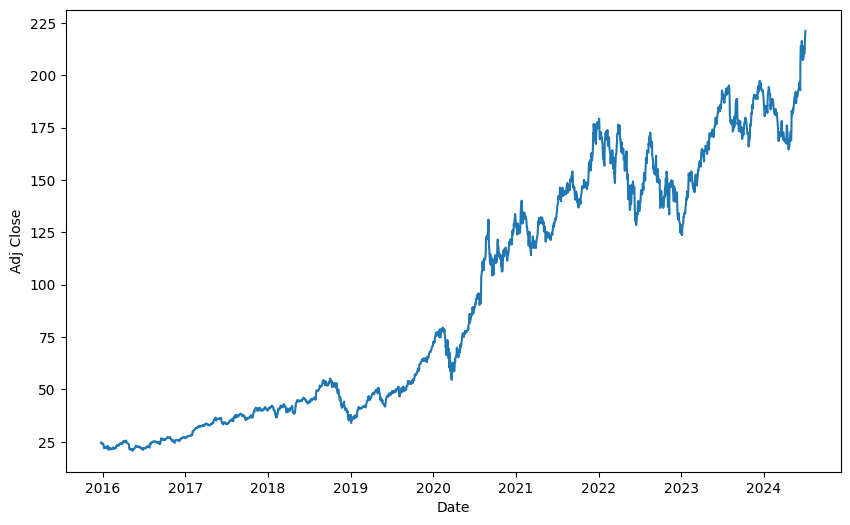

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.lineplot(data=df.loc[df['Ticker'] == 'AAPL', :], x='Date', y='Adj Close')

plt.show()

In [ ]:
# val_date_start = df['Date'].quantile(0.70)
# test_date_start = df['Date'].quantile(0.85)

# df_train = df.loc[df['Date'] < val_date_start, :].reset_index(drop=True)
# df_val = df.loc[df['Date'].between(val_date_start, test_date_start, inclusive='left'), :].reset_index(drop=True)
# df_test = df.loc[df['Date'] >= test_date_start, :].reset_index(drop=True)

# df_train.shape, df_val.shape, df_test.shape

In [ ]:
# # train data: 2015 until 2020
# df_train = df.loc[df['Date'].dt.year < 2020, :].reset_index(drop=True)

# # validation data: 2020 and 2021
# df_val = df.loc[df['Date'].dt.year.between(2020, 2022, inclusive='left'), :].reset_index(drop=True)

# # test data: 2022 onwards
# df_test = df.loc[df['Date'].dt.year >= 2022, :].reset_index(drop=True)

# df_train.shape, df_val.shape, df_test.shape

Try cross-sectional split such that train-val-test all get information from each type of market

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

test_splitter = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=22)

train_idx, test_idx = next(test_splitter.split(df, groups=df['Ticker']))

df_test = df.iloc[test_idx, :].reset_index(drop=True)
df_train = df.iloc[train_idx, :].reset_index(drop=True)

val_splitter = GroupShuffleSplit(test_size=1/3, n_splits=1, random_state=22)

train_idx, val_idx = next(val_splitter.split(df_train, groups=df_train['Ticker']))

df_val = df_train.iloc[val_idx, :].reset_index(drop=True)
df_train = df_train.iloc[train_idx, :].reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape

((29145, 31), (17152, 31), (17152, 31))

In [ ]:
df_train['Ticker'].unique()

array(['AAPL', 'CAT', 'CVX', 'DOW', 'GS', 'HD', 'INTC', 'JNJ', 'JPM',
       'MRK', 'MSFT', 'UNH', 'WBA', 'WMT'], dtype=object)

In [ ]:
df_val['Ticker'].unique()

array(['AXP', 'CSCO', 'DIS', 'HON', 'IBM', 'KO', 'MCD', 'NKE'],
      dtype=object)

In [ ]:
df_test['Ticker'].unique()

array(['AMGN', 'BA', 'CRM', 'MMM', 'PG', 'TRV', 'V', 'VZ'], dtype=object)

In [ ]:
df_train.to_parquet('../../data/model_data/training_data.parquet')
df_val.to_parquet('../../data/model_data/validation_data.parquet')
df_test.to_parquet('../../data/model_data/testing_data.parquet')

print('Done')

Done
